# Sentinel 2

The following notebook is used to work with sentinel 2 images. More specifically, it covers:
- fetching path for s2 images in specific folder
- Loading bands
- clipping bands
- showing bands as RGB image


Firstly, appending folder with senitnel 2 images

For info on downloding image, see the notebook 

For info on unzipping the images, see the notebook unzip

In [2]:
import sys
import matplotlib.pyplot as plt
import s2
import os
path_s2 = sys.path.append('C:\\Users\\krist\\Documents\\Syntese\\sokndal\\s2\\')
import matplotlib.patches as patches

In [48]:
import os
import s2
import numpy as np
import math
import s2

def load_stack(path,Verbose=0):
    """
        This function loads a stack of sentinel 2 images.
        
        input:
            path[str]: table of strings containing paths
            Verbose[int]: display info
            
        Output:
            images[array]: table of s2 stacked images.
            rasterio_obj[str]: table of rasterio objects.
            
        Example:
            images, rasterio_obj = load_stack(path_img,Verbose=2)
            
    """
    images = [];
    rasterio_obj = [];    
    for i in range(len(path)):
        if Verbose>1:
            print('\n(load_stack): Loading image '+str(i+1))
        im, r = load_bands(path[i],bands=['B02','B03','B04','B11','B12'],verbose=Verbose)
        images.append(im)
        rasterio_obj.append(r)
        
        if Verbose>1:
            print('\n(load_stack): Image '+str(i+1)+' Loaded')
            
    if Verbose>1:
        print('\n(load_stack): All '+str(len(path_img))+' images have been loaded.')
        
    return images, rasterio_obj



def stack_clip(images,Crop=True,Cliphigh=0.9,Cliplow=0.1):
    """
    
    """
    images_clipped = []
    for i in range(len(images)):
        images_clipped.append(img_clip(images[i],cliphigh=Cliphigh,cliplow=Cliplow))
        
    return images_clipped


def stack_rgb(images):
    """
    """
    rgb_stack = []    
    
    for i in range(len(images)):
        if len(images[i])==3:
            rgb = s2.rgb_img(images[i][2],images[i][1],images[i][0])
        if len(images[i])!=3:
            print('Warning: image'+str(i)+' has not enough bands!')

        #rgb_stack = np.stack(rgb_stack,rgb,axis=0)
        rgb_stack = np.dstack((rgb,rgb))
        #rgb_stack = np.concatenate((rgb_stack,rgb), axis=2) 
        #rgb_stack = np.append(rgb_stack, rgb, axis=1)
        print('sadasd')
    
    
    return rgb_stack
            
    

def stack_plot(images,path=''):
    """
    """
    
    fig, axs = plt.subplots(math.ceil(len(images)/2),2, figsize=(12,12), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    
    for i in range(len(images)):
        axs[i].imshow(images[i],cmap='binary')
        #axs[i].imshow(images[i],cmap='RdYlBu')
        axs[i].axis('off')
        if path!='':
            axs[i].set_title(path[i][17:21]+'-'+path[i][21:23]+'-'+path[i][23:25])
    return None
            
    
def get_s2_path(path):
    """
    """
    path_img=[]
    for root, dirs, files in os.walk(path):
        for d in dirs:
            if (os.path.relpath(os.path.join(root, d), ".")).endswith('IMG_DATA'):
                path_img.append(os.path.relpath(os.path.join(root, d), "."))
                #print (os.path.relpath(os.path.join(root, d), "."))
        for f in files:
            if (os.path.relpath(os.path.join(root, f), ".")).endswith('IMG_DATA'):
                path_img.append(os.path.relpath(os.path.join(root, f), "."))
                #print (os.path.relpath(os.path.join(root, f), "."))
    if len(path_img):
        print(len(path_img),' sentinel 2 images found in folder.')
        
    return path_img    

import numpy as np
import rasterio
import glob, os
import os.path  
import skimage
import skimage.morphology
import skimage.measure
import pandas as pd
import geopandas
from shapely.geometry import Polygon
from itertools import compress


def load_bands(path,bands,verbose=0):
    """
    load_bands(path,bands):
    
    This function loads images of type .jp2 from a IMG_DATA folder definded from "path".
    The images are loaded as numpy arrays(NxM) in a list of size "bands". 
     
    Supported for L2A products
    object cant be returned for L1C products
    
    Version 1.2
    ================================================
    Input:
        path(str) = path img IMG_DATA folder.
        bands(list of str) = A list of strings containing the band names.
    
    Output: 
        img_container(list) = A list of size (bands) containing each band as a numpy array image of same size.
        rasterio_obj(list) = A list of rasterio objects. Usefull for coordinate transformation. 
                            !!! Only works frot R10m rest is returned as None "                          
    
    Example:
        get list of images:
        images = load_bands('F:\\S2_billeder\\..\\IMG_DATA',bands=['B03','B04','B05','B01'])
    
    Author:
        Krisitan Sørensen
        Revised: May 2020
    
    """
    ####################################
    # Assertions
    ####################################    
    assert len(bands)>0,"No bands are given"
    
    Driver='JP2OpenJPEG'
    
    #count number og .jp2 files in .IMG folder. If there is some, if old format
    # if none, then theres subfolders and new format.
    folder = glob.glob(os.path.join(path,"*.jp2"))
    if (len(folder)>0):
        data_type = 'L1C'
        print('(Load_bands message) Image is L1C format.')
    else:
        data_type = 'L2A'
        print('(Load_bands message) Image is L2A format.')
        assert os.path.exists(os.path.join(path,'R10m')),"band folders doesn't exist in path folder"
        
    
    
    ####################################
    #Loading the bands
    ####################################
    
    img_container = []
    rasterio_obj = []
    #in data_type='new', the images are found in different subfolders.
    if (data_type =='L2A'):
        for i in range(len(bands)):
            #For bands B02,B03,B04 and B08, chaning path to R10m(10 m resolutuon)
            if (bands[i]=='B02') or (bands[i]=='B03') or (bands[i]=='B04')  or (bands[i]=='B08') or (bands[i]=='AOT') or (bands[i]=='TCI') or (bands[i]=='WVP'):    
                img_path = os.path.join(path,'R10m')
                img_path = os.path.join(img_path,'')
                img_extend = bands[i]+"_10m.jp2"
                for file in os.listdir(img_path):
                    if file.endswith(img_extend):
                        img = rasterio.open(img_path+file, driver=Driver)
                        rasterio_obj.append(img)
                        img_container.append((np.asarray(img.read(window=((0,img.shape[0]),(0,img.shape[1])))))[0,:,:])
                        if verbose==1:
                            print(bands[i],' loaded')
                                   
            if (bands[i]=='B05') or (bands[i]=='B06') or (bands[i]=='B07')  or (bands[i]=='B11') or (bands[i]=='B12') or (bands[i]=='SCL'):
                img_path = os.path.join(path,'R20m')
                img_path = os.path.join(img_path,'')
                img_extend = bands[i]+"_20m.jp2"
                for file in os.listdir(img_path):
                    if file.endswith(img_extend):
                        img = rasterio.open(img_path+file, driver=Driver)
                        rasterio_obj.append(img)
                        img = (np.asarray(img.read(window=((0,img.shape[0]),(0,img.shape[1])))))[0,:,:]
                        img = np.repeat(img, 2, axis=0)
                        img = np.repeat(img, 2, axis=1)
                        img = img.astype('float')
                        img_container.append(img)
                        if verbose==1:
                            print(bands[i],' loaded')
                        
            # 
            if (bands[i]=='B01') or (bands[i]=='B09'):
                # Aerosol Optical Thickness AOT. 
                img_path = os.path.join(path,'R60m')
                img_path = os.path.join(img_path,'')
                img_extend = bands[i]+"_60m.jp2"
                for file in os.listdir(img_path):
                    if file.endswith(img_extend):
                        img = rasterio.open(img_path+file, driver=Driver)
                        rasterio_obj.append(img)
                        img = (np.asarray(img.read(window=((0,img.shape[0]),(0,img.shape[1])))))[0,:,:]
                        img = np.repeat(img, 6, axis=0)
                        img = np.repeat(img, 6, axis=1)
                        img = img.astype('float')
                        img_container.append(img)
                        if verbose==1:
                            print(bands[i],' loaded')
    
    #if data_type ='old', all .jp2 files is in .IMG folder.
    elif (data_type=='old'):
        for i in range(len(folder)):
            for j in range(len(bands)):
                if folder[i].endswith(bands[j]+'.jp2'):
                    img = rasterio.open(folder[i], driver=Driver)
                    rasterio_obj.append(None)
                    img = (np.asarray(img.read(window=((0,img.shape[0]),(0,img.shape[1])))))[0,:,:]
                    
                    if (bands[j]=='B05') or (bands[j]=='B06') or (bands[j]=='B07')  or (bands[j]=='B11') or (bands[j]=='B12') or (bands[j]=='SCL'):
                        img = np.repeat(img, 2, axis=1)
                        img = np.repeat(img, 2, axis=0)
                        img_container.append(img)
                        if verbose==1:
                            print(bands[j],' loaded')    
                    elif (bands[j]=='B01') or (bands[j]=='B09') or (bands[j]=='B10'):
                        img = np.repeat(img, 6, axis=1)
                        img = np.repeat(img, 6, axis=0)
                        img_container.append(img)
                        if verbose==1:
                            print(bands[j],' loaded')
                     
        
        
    return img_container, rasterio_obj


def rgb_img(r,g,b):
    """
    rgb color representation.
    just illustration.. 
    (NxMx3) -> (NxMx1)
    """
    
    #color_image = np.stack((r*100,(g*42), (b*10)), axis=2)
    color_image = np.stack((r,g, b), axis=2)
    color_image = color_image/np.quantile(color_image,0.99)
    
    return color_image


def img_clip(img,cliphigh=0.9,cliplow=0.1):
    """
    Just at simple clipping used for our stuff.
    Maybe use CFAR later? (not)
    
    """
    for i in range(len(img)):
        img[i] = np.clip(img[i], np.quantile(img[i],cliplow), np.quantile(img[i],cliphigh))
        
    img_clipped = img
    
    return img_clipped

### Getting the paths for all images in the folder.
Each path correspongs to one image, and will be stored in \textttt{path_{img}}

In [4]:
path = 'C:\\Users\\krist\\Documents\\Syntese\\sokndal\\s2\\'
path_img=  get_s2_path(path)

11  sentinel 2 images found in folder.


### Loading images and raster info
The number of images is printed above. It is now possible to work with one iamge, i.e path_img[i], 
of with all the images, path_img, e.g. in a loop.

To verity, display the path of the second image:

In [5]:
images, rasterio_obj = load_stack(path_img,Verbose=2)


(load_stack): Loading image 1
(Load_bands message) Image is L2A format.

(load_stack): Image 1 Loaded

(load_stack): Loading image 2
(Load_bands message) Image is L2A format.

(load_stack): Image 2 Loaded

(load_stack): Loading image 3
(Load_bands message) Image is L2A format.

(load_stack): Image 3 Loaded

(load_stack): Loading image 4
(Load_bands message) Image is L2A format.

(load_stack): Image 4 Loaded

(load_stack): Loading image 5
(Load_bands message) Image is L2A format.

(load_stack): Image 5 Loaded

(load_stack): Loading image 6
(Load_bands message) Image is L2A format.

(load_stack): Image 6 Loaded

(load_stack): Loading image 7
(Load_bands message) Image is L2A format.

(load_stack): Image 7 Loaded

(load_stack): Loading image 8
(Load_bands message) Image is L2A format.

(load_stack): Image 8 Loaded

(load_stack): Loading image 9
(Load_bands message) Image is L2A format.

(load_stack): Image 9 Loaded

(load_stack): Loading image 10
(Load_bands message) Image is L2A format.

Each folder contains several bands. Each band is usefull for different things, see e.g. (LIKN TIL S2)...
Here, the regular RGB bands are used, as well as the NIR band which is better for fire.



Each band, for the chosen sentinel 2 image is loaded using the function load_bands().




If verbose>0, infromation is shown. We can then see, that the bands are indeed loaded. These bands values are out of range for plotting. Therefore, if they need to be illustrated, they must be clipped.

### Removing saturated values..

The function img_clip() clips the saturated values. change this to something better..

In [6]:
stack_clip = stack_clip(images,Cliphigh=0.9,Cliplow=0.1)

### Illustrating S2 using rgb_img

the area is found here: https://www.dr.dk/nyheder/udland/video-11-helikoptere-kaemper-med-norske-skovbrande-omraade-svarende-til-1000

In [13]:
x1 = 1700
y1 = 3700
x2 = 4000
y2 = 6000

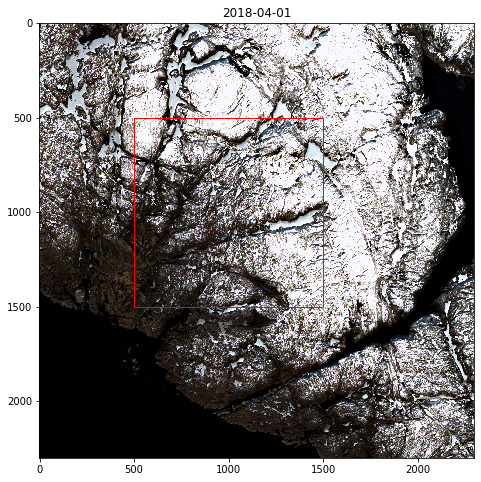

In [19]:
m=0
img1 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
img1.shape
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img1)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

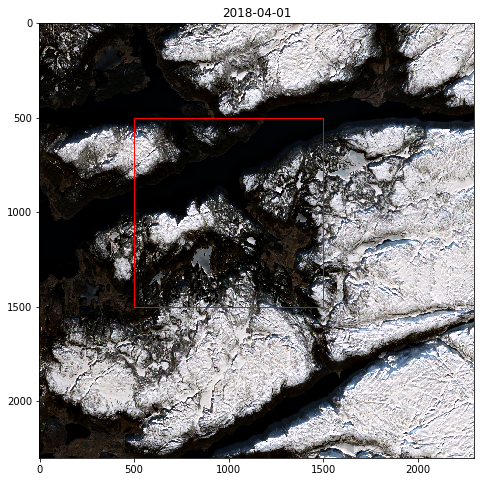

In [20]:
m=1
img2 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img2)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()


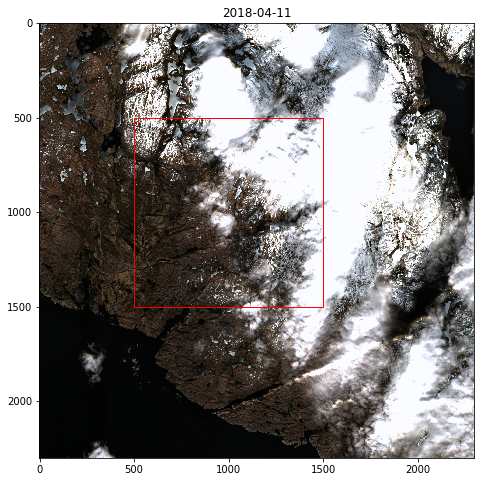

In [21]:
m=2
img3 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img3)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


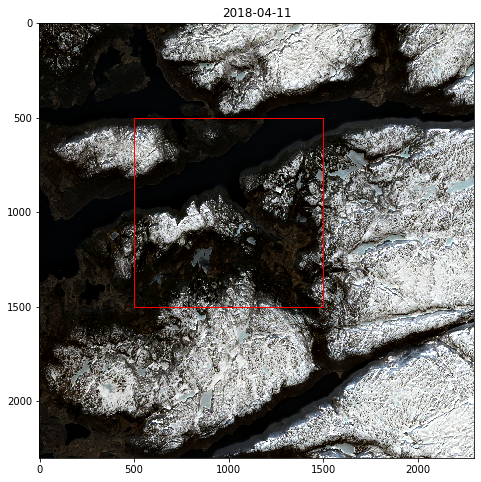

In [22]:
m=3
img4 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img4)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

Now, this can be combined in a function

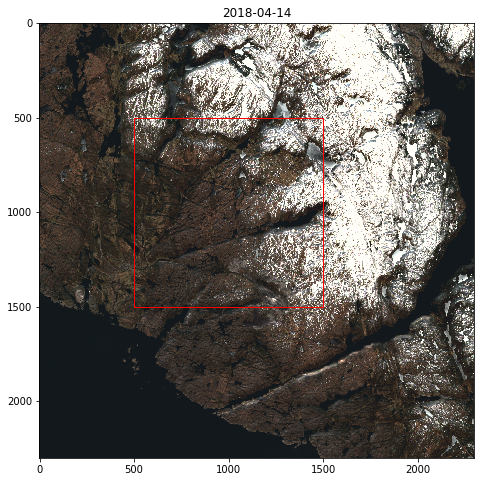

In [23]:
m=4
img5 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img5)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

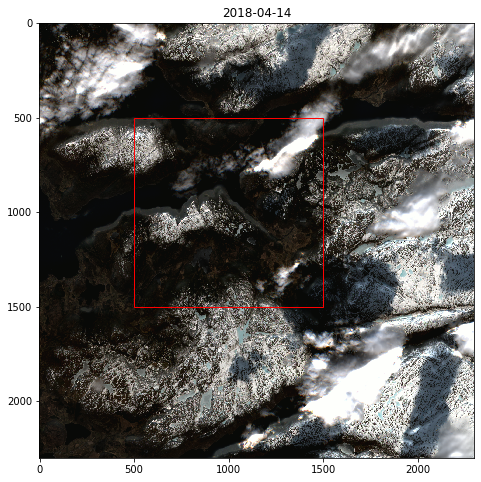

In [24]:
m=5
img6 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img6)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

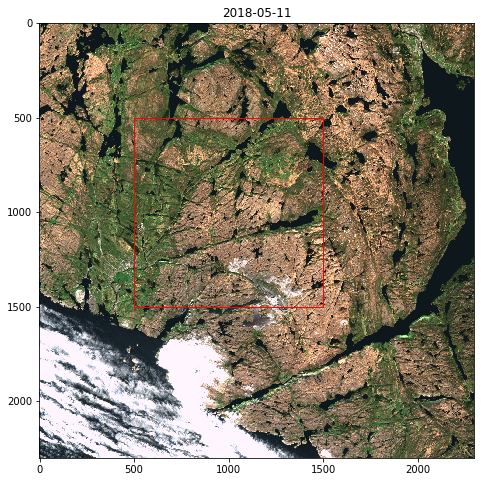

In [25]:
m=6
img7 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img7)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

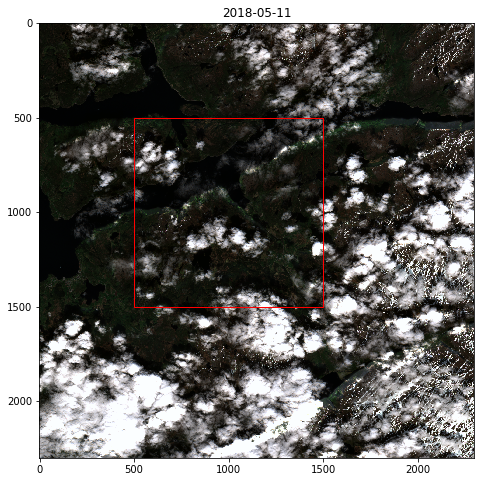

In [26]:
m=7
img8 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img8)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

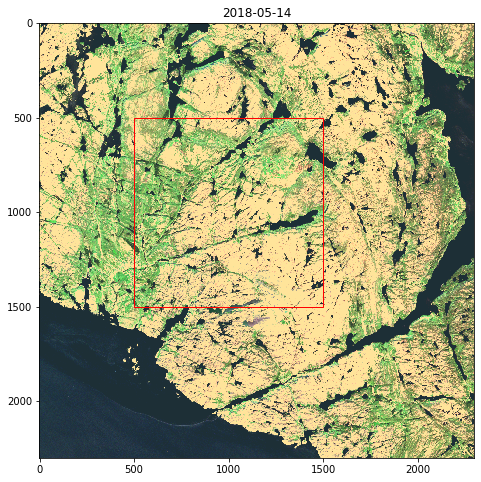

In [27]:
m=8
img9 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img9)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


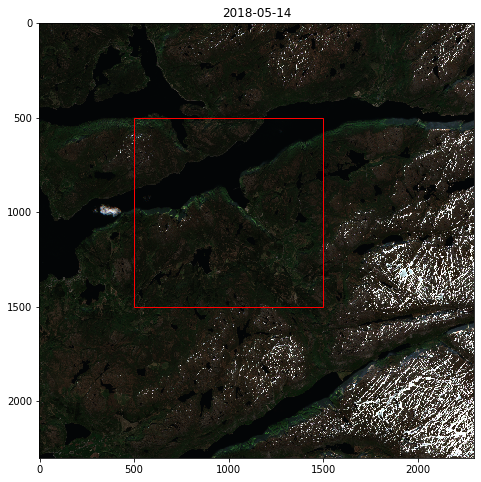

In [31]:
m=10
img11 = s2.rgb_img(stack_clip[m][2][x1:x2,y1:y2],stack_clip[m][1][x1:x2,y1:y2],stack_clip[m][0][x1:x2,y1:y2])
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(img11)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
ax.add_patch(rect)
plt.show()

# Normalized burn ratio

In [47]:
#brn
img_april, rasterio_obj_arpil = load_stack([path_img[4]],Verbose=2)


(load_stack): Loading image 1
(Load_bands message) Image is L2A format.
s2\S2A_MSIL2A_20180414T105651_N0207_R094_T32VLK_20180414T113113.SAFE\GRANULE\L2A_T32VLK_A014677_20180414T105916\IMG_DATA

(load_stack): Image 1 Loaded

(load_stack): All 11 images have been loaded.


In [51]:
len(img_april[0])

5

normalized burn ration m[ske

In [56]:
brun = (np.array(img_april[0][3][x1:x2,y1:y2])-np.array(img_april[0][4][x1:x2,y1:y2]))/(np.array(img_april[0][3][x1:x2,y1:y2])+np.array(img_april[0][4][x1:x2,y1:y2]));

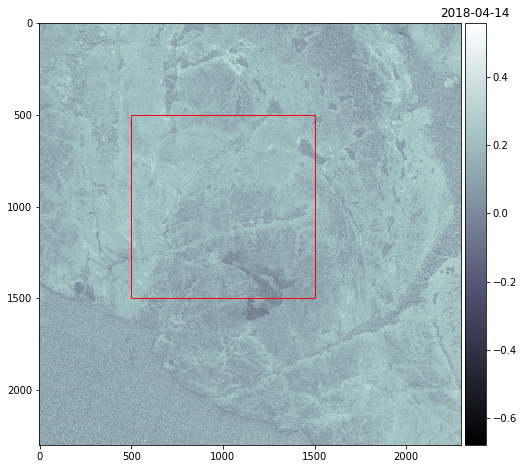

In [69]:
m=4
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(8,8))
#ax.imshow(brun)
rect = patches.Rectangle((500,500),1000,1000,linewidth=1,edgecolor='r',facecolor='none')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# Add the patch to the Axes
plt.title(str(path_img[m][14:18])+'-'+str(path_img[m][18:20])+'-'+str(path_img[m][20:22]))
im = ax.imshow(brun, cmap='bone')
fig.colorbar(im, cax=cax, orientation='vertical')
ax.add_patch(rect)
plt.show()